In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1` instance, that we wrap in a `ProblemWrapper`. In nmoo, `ProblemWrapper` is the base class to modify problems, in our case adding and removing noise. Additionally, `ProblemWrapper` and classes deriving from it maintain a history of every call made to their `_evaluate` method (see the [pymoo documentation](https://pymoo.org/getting_started.html#By-Class)).

In [2]:
from pymoo.problems.multi import ZDT1

zdt1 = ZDT1()
wrapped_zdt1 = nmoo.utils.ProblemWrapper(zdt1)

Then, we add a Gaussian noise of type `N(0, 0.25)`, and our two candidate denoising algorithms.

In [3]:
noisy_zdt1 = nmoo.noises.GaussianNoise(wrapped_zdt1, {"F": (0.0, 0.25)})

avg_zdt1 = nmoo.denoisers.Average(noisy_zdt1, n_evaluations=5)

knnavg_zdt1 = nmoo.denoisers.KNNAvg(
    noisy_zdt1,
    distance_weight_type="squared",
    max_distance=1.0,
    n_neighbors=10,
)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling

nsga2 = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", prob=1.0, eta=20),
    eliminate_duplicates=True,
)

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and `knnavg_zdt1` three times each. Additionally, we specify a Pareto front population to measure the performance, not of NSGA2, but of KNN-Avg against the averaging method.

In [5]:
pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.benchmark.Benchmark(
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        # It is of course possible to specify more than 1 algorithm
    },
    n_runs=5,
)

In [6]:
%%time
benchmark.run()

[1/10] Problem: knnavg, Algorithm: nsga2, Run: 1/5
[2/10] Problem: knnavg, Algorithm: nsga2, Run: 2/5
[3/10] Problem: knnavg, Algorithm: nsga2, Run: 3/5
[4/10] Problem: knnavg, Algorithm: nsga2, Run: 4/5
[5/10] Problem: knnavg, Algorithm: nsga2, Run: 5/5
[6/10] Problem: avg, Algorithm: nsga2, Run: 1/5
[7/10] Problem: avg, Algorithm: nsga2, Run: 2/5
[8/10] Problem: avg, Algorithm: nsga2, Run: 3/5
[9/10] Problem: avg, Algorithm: nsga2, Run: 4/5
[10/10] Problem: avg, Algorithm: nsga2, Run: 5/5
CPU times: user 3min 40s, sys: 1min 54s, total: 5min 34s
Wall time: 5min 43s


We now dump all results and histories for later analysis

In [7]:
OUT_PATH = "./out"
if not os.path.isdir(OUT_PATH):
    os.mkdir(OUT_PATH)
benchmark.dump_everything(OUT_PATH)

The following file should appear in `./out`:
* `avg.1.npz`: `avg_zdt1` call history;
* `avg.2.npz`: `noisy_zdt1` call history;
* `avg.3.npz`: `wrapped_zdt1` call history;
* `benchmark.csv`: benchmark results;
* `knnavg.1.npz`: `knnavg_zdt1` call history;
* `knnavg.2.npz`: `noisy_zdt1` call history;
* `knnavg.3.npz`: `wrapped_zdt1` call history.

Note that since `wrapped_zdt1` and `noisy_zdt1` were reused in both pipelines, the contents of `avg.3.npz` and `knnavg.3.npz` will be identical, and likewise for `avg.2.npz` and `knnavg.2.npz`.

In [8]:
! ls -l ./out

total 95120
-rw-r--r--  1 cedric  staff   4242206 Jun  6 17:05 avg.1.npz
-rw-r--r--  1 cedric  staff  11293214 Jun  6 17:05 avg.2.npz
-rw-r--r--  1 cedric  staff   8620221 Jun  6 17:05 avg.3.npz
-rw-r--r--  1 cedric  staff    417713 Jun  6 17:05 benchmark.csv
-rw-r--r--  1 cedric  staff   4200893 Jun  6 17:05 knnavg.1.npz
-rw-r--r--  1 cedric  staff  11293214 Jun  6 17:05 knnavg.2.npz
-rw-r--r--  1 cedric  staff   8620221 Jun  6 17:05 knnavg.3.npz


Let's now visualize the results. The final result of each of the 6 runs can be found using the `Benchmark.final_results` method:

In [9]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,timedelta,perf_gd,perf_gd+,perf_igd,perf_igd+
0,nsga2,avg,1,325,12285,0.398302,0.391464,0.232831,0.227879
1,nsga2,avg,2,335,625259,0.619388,0.607888,0.207781,0.204005
2,nsga2,avg,3,420,726561,0.422662,0.415503,0.185023,0.183418
3,nsga2,avg,4,245,158808,0.737496,0.732090,0.327018,0.320998
4,nsga2,avg,5,410,974301,0.492821,0.473247,0.113459,0.088390
5,nsga2,knnavg,1,435,254486,0.794302,0.746995,0.235656,0.225066
6,nsga2,knnavg,2,430,872986,0.593469,0.553953,0.138910,0.128265
7,nsga2,knnavg,3,303,58022,1.270369,1.238809,0.350086,0.334854
8,nsga2,knnavg,4,180,29001,0.908617,0.876252,0.209147,0.170771
9,nsga2,knnavg,5,370,523991,1.130118,1.089661,0.230418,0.215371


On average, KNN-Avg offers a better GD+ performance

<AxesSubplot:xlabel='problem', ylabel='perf_gd+'>

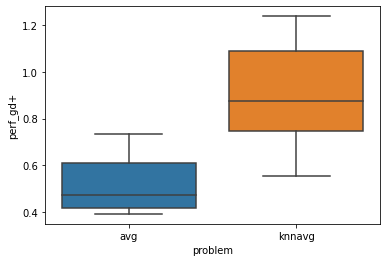

In [10]:
import seaborn as sns

sns.boxplot(x="problem", y="perf_gd+", data=benchmark.final_results())

KNN-Avg also runs slightly faster (even without controlling the termination criterion of NSGA2), since fewer calls are made to the underlying problem. The difference can become significant if the base problem is costly to evaluate.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

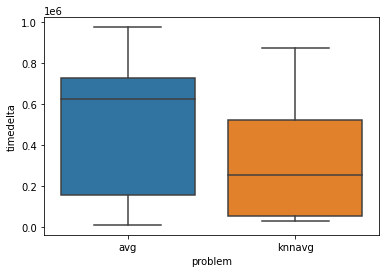

In [11]:
sns.boxplot(x="problem", y="timedelta", data=benchmark.final_results())